In [1]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")
n = ['id', 'date', 'name', 'text', 'typr', 'rep', 'rtw', 'faw', 'stcount', 'foll', 'frien', 'listcount']
data_positive = pd.read_csv('data/positive.csv', sep=';', error_bad_lines=False, names=n, usecols=['text'])
data_negative = pd.read_csv('data/negative.csv', sep=';', error_bad_lines=False, names=n, usecols=['text'])

sample_size = min(data_positive.shape[0], data_negative.shape[0])
raw_data = np.concatenate((data_positive['text'].values[:sample_size],
                           data_negative['text'].values[:sample_size]), axis=0)
labels = [1] * sample_size + [0] * sample_size

In [2]:
import re

def preprocess_text(text):
    text = text.lower().replace("ё", "е")
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)
    text = re.sub('@[^\s]+', 'USER', text)
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub(' +', ' ', text)
    return text.strip()


data = [preprocess_text(t) for t in raw_data]

In [3]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=2)

In [4]:
from keras import backend as K


def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [5]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

SENTENCE_LENGTH = 26
NUM = 100000

def get_sequences(tokenizer, x):
    sequences = tokenizer.texts_to_sequences(x)
    return pad_sequences(sequences, maxlen=SENTENCE_LENGTH)

tokenizer = Tokenizer(num_words=NUM)
tokenizer.fit_on_texts(x_train)

x_train_seq = get_sequences(tokenizer, x_train)
x_test_seq = get_sequences(tokenizer, x_test)

In [6]:
from gensim.models import Word2Vec
w2v_model = Word2Vec.load('models/w2v/tweets_model.w2v')
DIM = w2v_model.vector_size
embedding_matrix = np.zeros((NUM, DIM))
for word, i in tokenizer.word_index.items():
    if i >= NUM:
        break
    if word in list(w2v_model.wv.index_to_key):
        embedding_matrix[i] = w2v_model.wv[word]

In [7]:
from keras.layers import Input
from keras.layers import Embedding

tweet_input = Input(shape=(SENTENCE_LENGTH,), dtype='int32')
tweet_encoder = Embedding(NUM, DIM, input_length=SENTENCE_LENGTH,
                          weights=[embedding_matrix], trainable=False)(tweet_input)

In [8]:
from keras import optimizers
from keras.layers import Dense, concatenate, Activation, Dropout
from keras.models import Model
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import GlobalMaxPooling1D

branches = []
x = Dropout(0.2)(tweet_encoder)

for size, filters_count in [(2, 10), (3, 10), (4, 10), (5, 10)]:
    for i in range(filters_count):
        branch = Conv1D(filters=1, kernel_size=size, padding='valid', activation='relu')(x)
        branch = GlobalMaxPooling1D()(branch)
        branches.append(branch)

x = concatenate(branches, axis=1)
x = Dropout(0.2)(x)
x = Dense(30, activation='relu')(x)
x = Dense(1)(x)
output = Activation('sigmoid')(x)

model = Model(inputs=[tweet_input], outputs=[output])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[precision, recall, f1])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 26)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 26, 200)      20000000    ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 26, 200)      0           ['embedding[0][0]']              
                                                                                                  
 conv1d (Conv1D)                (None, 25, 1)        401         ['dropout[0][0]']                
                                                                                              

In [9]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("models/cnn/cnn-frozen-embeddings-{epoch:02d}-{val_f1:.2f}.hdf5",
                             monitor='val_f1', save_best_only=True, mode='max', save_freq='epoch')
history = model.fit(np.array(x_train_seq), np.array(y_train), batch_size=32, epochs=10, validation_split=0.25, callbacks = [checkpoint])

Epoch 1/10
4198/4198 [==============================] - 122s 28ms/step - loss: 0.5708 - precision: 0.6988 - recall: 0.6984 - f1: 0.6895 - val_loss: 0.4997 - val_precision: 0.7463 - val_recall: 0.7711 - val_f1: 0.7523
Epoch 2/10
4198/4198 [==============================] - 114s 27ms/step - loss: 0.5153 - precision: 0.7402 - recall: 0.7380 - f1: 0.7312 - val_loss: 0.4867 - val_precision: 0.7809 - val_recall: 0.7203 - val_f1: 0.7428
Epoch 3/10
4198/4198 [==============================] - 118s 28ms/step - loss: 0.5026 - precision: 0.7464 - recall: 0.7450 - f1: 0.7388 - val_loss: 0.4792 - val_precision: 0.7750 - val_recall: 0.7418 - val_f1: 0.7519
Epoch 4/10
4198/4198 [==============================] - 118s 28ms/step - loss: 0.4940 - precision: 0.7552 - recall: 0.7515 - f1: 0.7463 - val_loss: 0.4744 - val_precision: 0.7802 - val_recall: 0.7406 - val_f1: 0.7537
Epoch 5/10
4198/4198 [==============================] - 113s 27ms/step - loss: 0.4878 - precision: 0.7576 - recall: 0.7530 - f1: 0.7

[0.6988255977630615, 0.7402028441429138, 0.7463781833648682, 0.7551876902580261, 0.757639467716217, 0.7638968229293823, 0.7646234035491943, 0.7664907574653625, 0.7673717737197876, 0.7681807279586792]


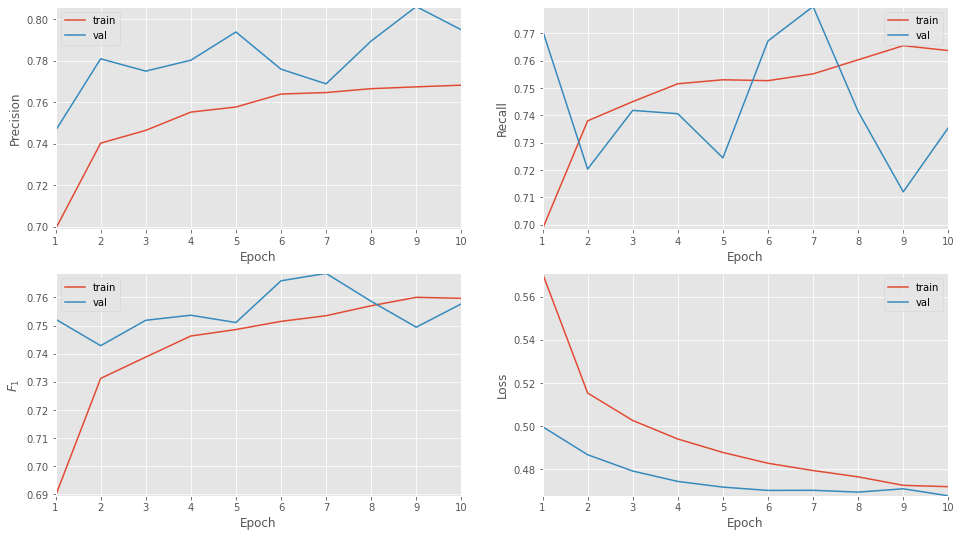

In [32]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')


def plot_metrix(ax, x1, x2, title):
    ax.plot(range(1, len(x1) + 1), x1, label='train')
    ax.plot(range(1, len(x2) + 1), x2, label='val')
    ax.set_ylabel(title)
    ax.set_xlabel('Epoch')
    ax.legend()
    ax.margins(0)


def plot_history(history):
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16, 9))
    ax1, ax2, ax3, ax4 = axes.ravel()
    print(history.history['precision'])
    plot_metrix(ax1, history.history['precision'], history.history['val_precision'], 'Precision')
    plot_metrix(ax2, history.history['recall'], history.history['val_recall'], 'Recall')
    plot_metrix(ax3, history.history['f1'], history.history['val_f1'], "$F_1$")
    plot_metrix(ax4, history.history['loss'], history.history['val_loss'], 'Loss')

    plt.show()


plot_history(history)

In [11]:
model.load_weights('models/cnn/cnn-frozen-embeddings-09-0.77.hdf5')

In [12]:
from sklearn.metrics import classification_report

predicted = np.round(model.predict(x_test_seq))
print(classification_report(y_test, predicted, digits=5))

1400/1400 [==============================] - 11s 8ms/step
              precision    recall  f1-score   support

           0    0.77499   0.77268   0.77383     22457
           1    0.77189   0.77421   0.77305     22313

    accuracy                        0.77344     44770
   macro avg    0.77344   0.77344   0.77344     44770
weighted avg    0.77345   0.77344   0.77344     44770



In [13]:
from keras import optimizers

model.layers[1].trainable = True
adam = optimizers.Adam(lr=0.0001)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[precision, recall, f1])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 26)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 26, 200)      20000000    ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 26, 200)      0           ['embedding[0][0]']              
                                                                                                  
 conv1d (Conv1D)                (None, 25, 1)        401         ['dropout[0][0]']                
                                                                                              

In [14]:
checkpoint = ModelCheckpoint("models/cnn/cnn-trainable-{epoch:02d}-{val_f1:.2f}.hdf5",
                             monitor='val_f1', save_best_only=True, mode='max', period=1)

history_trainable = model.fit(np.array(x_train_seq), np.array(y_train), batch_size=32, epochs=5, validation_split=0.25, callbacks = [checkpoint])

Epoch 1/5
4198/4198 [==============================] - 154s 36ms/step - loss: 0.4623 - precision: 0.7703 - recall: 0.7746 - f1: 0.7669 - val_loss: 0.4610 - val_precision: 0.7817 - val_recall: 0.7651 - val_f1: 0.7676
Epoch 2/5
4198/4198 [==============================] - 149s 36ms/step - loss: 0.4547 - precision: 0.7769 - recall: 0.7763 - f1: 0.7708 - val_loss: 0.4582 - val_precision: 0.7897 - val_recall: 0.7570 - val_f1: 0.7671
Epoch 3/5
4198/4198 [==============================] - 153s 36ms/step - loss: 0.4478 - precision: 0.7827 - recall: 0.7814 - f1: 0.7766 - val_loss: 0.4556 - val_precision: 0.7871 - val_recall: 0.7689 - val_f1: 0.7720
Epoch 4/5
4198/4198 [==============================] - 153s 36ms/step - loss: 0.4416 - precision: 0.7872 - recall: 0.7844 - f1: 0.7804 - val_loss: 0.4539 - val_precision: 0.7966 - val_recall: 0.7529 - val_f1: 0.7679
Epoch 5/5
4198/4198 [==============================] - 156s 37ms/step - loss: 0.4358 - precision: 0.7924 - recall: 0.7878 - f1: 0.7846 -

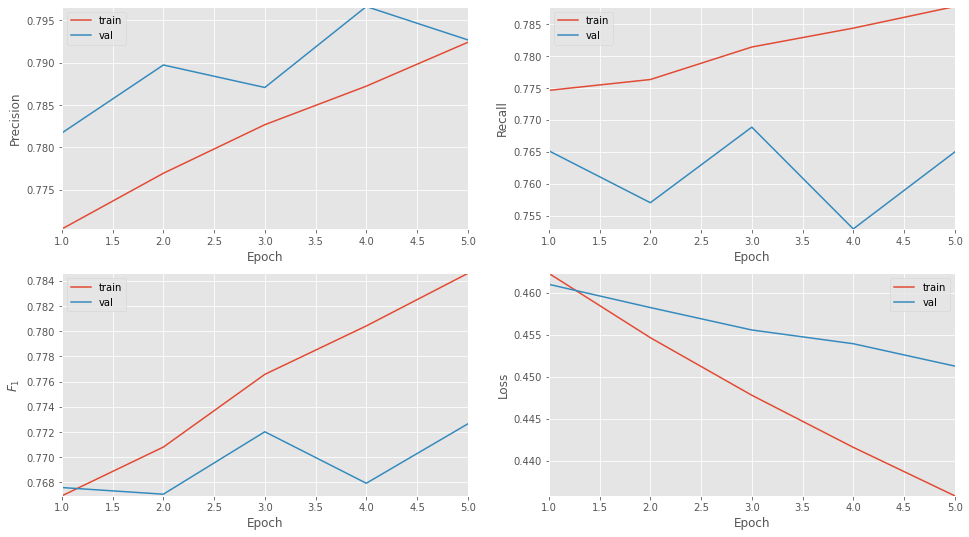

In [15]:
plot_history(history_trainable)

In [16]:
model.load_weights('models/cnn/cnn-trainable-03-0.78.hdf5')

In [17]:
predicted = np.round(model.predict(x_test_seq))
print(classification_report(y_test, predicted, digits=5))

1400/1400 [==============================] - 11s 8ms/step
              precision    recall  f1-score   support

           0    0.78191   0.78243   0.78217     22457
           1    0.78088   0.78035   0.78061     22313

    accuracy                        0.78139     44770
   macro avg    0.78139   0.78139   0.78139     44770
weighted avg    0.78139   0.78139   0.78139     44770



In [24]:
data_test = pd.read_csv('data/test.csv', sep=';', error_bad_lines=False, names=n, usecols=['text', 'foll'], encoding="Windows-1251")

sample_size = min(data_test.shape[0], 99999999)
print(data_test)
print(data_test.shape[0], data_test['text'].values)
raw_data = data_test['text'].values[:sample_size]
labels = [1] * sample_size + [0] * sample_size
data_t = [preprocess_text(t) for t in raw_data]
t_test = data_t
t_str = "люблю уточек и шлёпу"
t_str_seq = get_sequences(tokenizer, t_str)
t_test_seq = get_sequences(tokenizer, t_test)
predicted = np.round(model.predict(t_test_seq))
print(*predicted)
i = 0
for reaction in predicted:
    if reaction[0] == 1:
        print("positive", data_test['text'].values[i])
    else:
        print("negative", data_test['text'].values[i])
    i += 1

                         text  foll
0               я люблю тебя     62
1          я ненавижу тебя :D    59
2           ты плохой человек    62
3        ты плохой человек :D    59
4                фильм отстой    62
5               фильм отстой)    59
6  самый отвратительный фильм    62
7             фильм отстой :D    59
8 ['я люблю тебя ' 'я ненавижу тебя :D' 'ты плохой человек'
 'ты плохой человек :D' 'фильм отстой' 'фильм отстой)'
 'самый отвратительный фильм' 'фильм отстой :D']
1/1 [==============================] - 0s 15ms/step
[1.] [1.] [0.] [1.] [0.] [0.] [0.] [1.]
positive я люблю тебя 
positive я ненавижу тебя :D
negative ты плохой человек
positive ты плохой человек :D
negative фильм отстой
negative фильм отстой)
negative самый отвратительный фильм
positive фильм отстой :D


[50, 100, 200, 400, 800, 1000, 2000, 4000, 8000, 10000, 20000, 40000, 50000, 100000]
[80354, 36282, 39788, 27780, 17816, 4558, 10882, 5888, 2906, 912, 1624, 578, 160, 294]
[93598, 35912, 31080, 26910, 15716, 3902, 8818, 4340, 1574, 448, 786, 484, 72, 206]
[0.85850125002671, 1.0103029627979505, 1.2801801801801802, 1.0323299888517279, 1.1336217867141767, 1.168118913377755, 1.2340666817872534, 1.3566820276497695, 1.846251588310038, 2.0357142857142856, 2.0661577608142494, 1.1942148760330578, 2.2222222222222223, 1.4271844660194175]


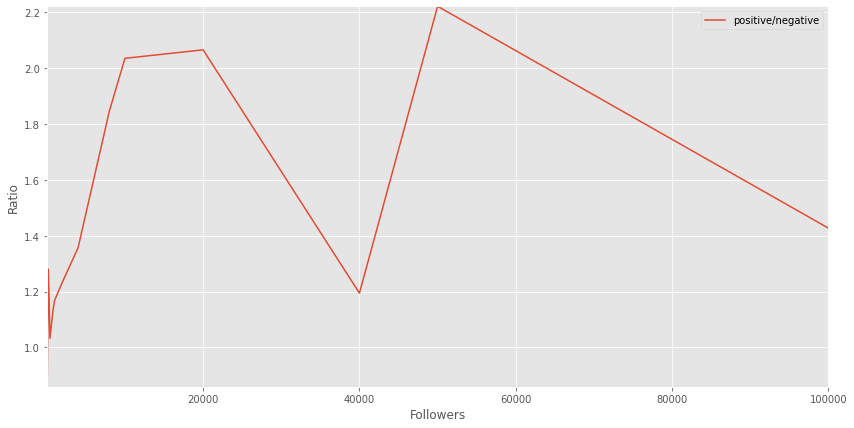

In [57]:
data_positive = pd.read_csv('data/positive.csv', sep=';', error_bad_lines=False, names=n, usecols=['foll'])
data_negative = pd.read_csv('data/negative.csv', sep=';', error_bad_lines=False, names=n, usecols=['foll'])
sample_size = min(data_test.shape[0], 99999999)
foll_ranks_positive = [[50,0], [100,0], [200,0], [400,0], [800,0], [1000,0], [2000,0], [4000,0], [8000,0], [10000,0], [20000,0], [40000,0], [50000,0], [100000,0]]
foll_ranks_negative = [[50,0], [100,0], [200,0], [400,0], [800,0], [1000,0], [2000,0], [4000,0], [8000,0], [10000,0], [20000,0], [40000,0], [50000,0], [100000,0]]
for tweet in data_positive['foll'].values:
    for j in range(len(foll_ranks_positive)):
        if tweet <= foll_ranks_positive[j][0] or j == len(foll_ranks_negative)-1:
            foll_ranks_positive[j][1] += 1
            break
for tweet in data_negative['foll'].values:
    for j in range(len(foll_ranks_negative)):
        if tweet <= foll_ranks_negative[j][0] or j == len(foll_ranks_negative)-1:
            foll_ranks_negative[j][1] += 1
            break

for tweet in data_positive['foll'].values:
    for j in range(len(foll_ranks_positive)):
        if tweet <= foll_ranks_positive[j][0] or j == len(foll_ranks_negative)-1:
            foll_ranks_positive[j][1] += 1
            break
for tweet in data_negative['foll'].values:
    for j in range(len(foll_ranks_negative)):
        if tweet <= foll_ranks_negative[j][0] or j == len(foll_ranks_negative)-1:
            foll_ranks_negative[j][1] += 1
            break
plt.style.use('ggplot')


def plot_state(ax, x1, x2, y):
    ax.plot(y, x1, label='positive/negative')
    ax.set_ylabel('Ratio')
    ax.set_xlabel('Followers')
    ax.legend()
    ax.margins(0)

ranks = []
stat_negative = []
stat_positive = []
stat_ratio = []
for i in range(len(foll_ranks_negative)):
    ranks.append(foll_ranks_negative[i][0])
    stat_negative.append(foll_ranks_negative[i][1])
for i in range(len(foll_ranks_positive)):
    stat_positive.append(foll_ranks_positive[i][1])
for i in range(len(foll_ranks_positive)):
    if stat_negative[i] == 0:
        stat_negative[i] = 1
    stat_ratio.append(stat_positive[i]/stat_negative[i])

print(ranks)
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(14, 7))
ax11 = axes
print(stat_positive)
print(stat_negative)
print(stat_ratio)
plot_state(ax11, stat_ratio, stat_negative, ranks)
plt.show()


In [71]:
w2v_model.wv.most_similar(positive=["боевик", "драма"], negative=["комедия"])


[('триллер', 0.7232926487922668),
 ('детектив', 0.5829720497131348),
 ('остросюжетный', 0.5695168972015381),
 ('биографический', 0.5672210454940796),
 ('боевика', 0.5456779599189758),
 ('телесериал', 0.5437925457954407),
 ('уничтожен', 0.5366279482841492),
 ('детективавтор', 0.5358017683029175),
 ('палестинского', 0.5155094861984253),
 ('эпос', 0.5086333751678467)]

In [72]:
w2v_model.wv.most_similar(positive=["боевик", "драма"])

[('триллер', 0.8409284353256226),
 ('комедия', 0.7966159582138062),
 ('мелодрама', 0.7298552989959717),
 ('остросюжетный', 0.6675755977630615),
 ('биографический', 0.6520490050315857),
 ('детектив', 0.6348611116409302),
 ('фэнтези', 0.624020516872406),
 ('фантастика', 0.6202371120452881),
 ('жанр', 0.6064211130142212),
 ('трилле', 0.6021350026130676)]

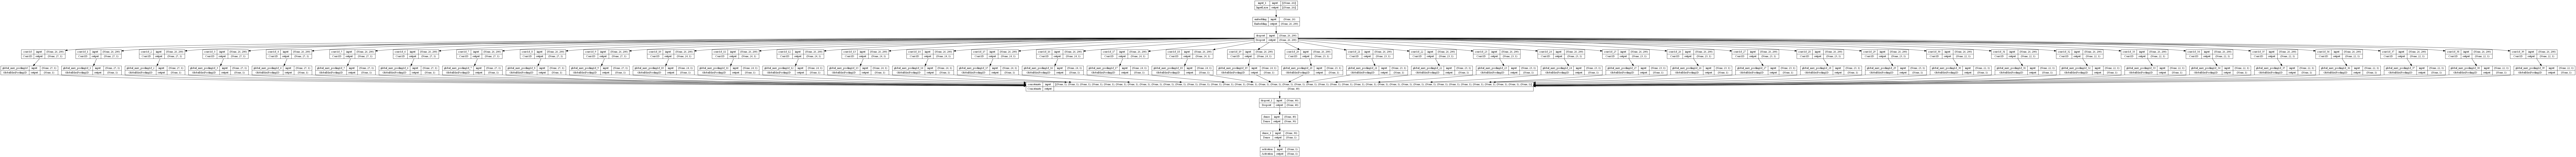

In [19]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)